In [1]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### Utility Functions

In [21]:
# get the RMSE of the results
def get_rmse(y_real, y_hat, label='test'):
    mse = mean_squared_error(y_real, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_real, y_hat)
    print('Dataset: {} RMSE:{}, R2:{}'.format(label, rmse, variance))

# adds the operating condition for the engine for each unit
# make a string to use as categorical variable
def add_op_co(df):
    op_co = df.copy()
    op_co['setting_1'] = op_co['setting_1'].round(decimals=1)
    op_co['setting_2'] = op_co['setting_2'].round(decimals=1)
    op_co['setting_3'] = op_co['setting_3'].round(decimals=1)
    op_co['op_cond'] = op_co['setting_1'].astype(str) + '-' + op_co['setting_2'].astype(str) + '-' + op_co['setting_3'].astype(str)
    return op_co

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

# need to remove noise from the signals or the LSTM is gonna be a mess
# https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
# https://stackoverflow.com/questions/60966612/how-to-use-exponential-smoothing-to-smooth-the-timeseries-in-python
# https://stackoverflow.com/questions/36511942/exponential-smoothing-function-issue-with-grouping-sizes

def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    df[sensors] = df.groupby('unit_id')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_id to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_id')['unit_id'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]
    
    return df

In [3]:
# sequence array generator for LSTM

# need to generate sequences for the LSTM to use
# Tensorflow has some functions for this, but not flexible enough to use with our dataset
# need custom generator because not all engines have sequences of the same size
# code adapted from --> https://github.com/Azure/lstms_for_predictive_maintenance
# https://realpython.com/introduction-to-python-generators/

def gen_train_seq(data, sequence_length, cols):
    data_out = data[cols].values
    size = data_out.shape[0]
    for start, stop in zip(range(0, size - (sequence_length-1)), range(sequence_length, size+1)):
        yield data_out[start:stop, :]
          
def label_generator(data, sequence_length, labels):
    data_out = data[labels].values
    size = data_out.shape[0]
    return data_out[sequence_length-1:size, :]

def test_padding(data, sequence_length, cols, m):
    size = data.shape[0]
    
    if size < sequence_length: # add padding of dummy nums
        padding = np.full(shape = ((sequence_length - size), len(cols)), fill_value = m)
        output = np.concatenate((padding, data[cols].values))
    else:
        output = data[cols].values
    
    # per predictive maintenance template we only want the last sequence from each test run
    #(https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2),
    
    stop = output.shape[0]
    start = stop - sequence_length
    
    for i in list(range(1)):
        yield(output[start:stop,:])
        
        

In [4]:
# import dataset!

dataset = "003"

training_file = 'CMAPSS_DATA/train_FD{}.txt'.format(dataset)
testing_file = 'CMAPSS_DATA/test_FD{}.txt'.format(dataset)
RUL_file = 'CMAPSS_DATA/RUL_FD{}.txt'.format(dataset)
index_names = ['unit_id', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names


train = pd.read_csv(training_file, sep='\s+', header=None, 
                 names=col_names)
test = pd.read_csv(testing_file, sep='\s+', header=None, 
                 names=col_names)
y_test = pd.read_csv(RUL_file, sep='\s+', header=None, 
                 names=['RemainingUsefulLife'])

print(train.shape)
train.head()


(24720, 26)


,unit_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [5]:
# need to attach the RUL for each cycle

# Get the max num of cycles for each unit & add to dataframe
group_by_unit = train.groupby(by="unit_id")
max_cycle = group_by_unit["time_cycles"].max()
RUL_column = train.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_id', right_index=True)
# for each row, get the difference from it to the max
remaining_useful_life = RUL_column["max_cycle"] - RUL_column["time_cycles"]
RUL_column["RUL"] = remaining_useful_life
# get rid of the max, dont need anymore
train = RUL_column.drop("max_cycle", axis=1)
train[index_names+['RUL']].head()

,unit_id,time_cycles,RUL
0,1,1,258
1,1,2,257
2,1,3,256
3,1,4,255
4,1,5,254


### Step 1: Try regular old regression!

In [6]:
# build up data for training the models

X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

# get last row of each engine
X_test = test.drop('time_cycles', axis=1).groupby('unit_id').last().copy() 

In [7]:


# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
get_rmse(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:63.49352602554267, R2:0.5873780509052733
Dataset: test RMSE:57.07620624036822, R2:-0.9010841978262856


Results are pretty not great compared to the LSTM paper, so hopefully there will be a pretty big improvement!

In [22]:
X_train_condition = add_op_co(train)
X_test_condition = add_op_co(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

X_train_condition.head()
X_train_condition

,unit_id,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,op_cond
0,1,1,-0.0,0.0,100.0,-1.0,-0.195751,-0.703646,-0.787224,-1.0,...,0.054285,0.479865,-1.0,-0.895116,0.0,0.0,0.471843,-0.270332,258,-0.0-0.0-100.0
1,1,2,0.0,-0.0,100.0,0.0,0.080412,-0.490468,-0.767303,-1.0,...,0.570510,0.721112,-1.0,-0.322193,0.0,0.0,0.013559,0.382248,257,0.0--0.0-100.0
2,1,3,-0.0,-0.0,100.0,-1.0,-0.529635,-0.843767,0.118287,-1.0,...,0.368970,-0.099784,-1.0,-0.884326,0.0,0.0,-0.550558,-0.170014,256,-0.0--0.0-100.0
3,1,4,-0.0,0.0,100.0,-1.0,0.877819,-0.355646,-1.257815,-1.0,...,0.127484,-0.132974,-1.0,-0.320974,0.0,0.0,-0.133639,-0.666262,255,-0.0-0.0-100.0
4,1,5,0.0,0.0,100.0,0.0,-1.479692,0.067720,-0.698997,-1.0,...,0.198769,-0.147755,-1.0,-0.324222,0.0,0.0,0.604750,0.430992,254,0.0-0.0-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0,-0.0,100.0,-1.0,2.552723,1.154186,2.018842,-1.0,...,-0.371998,1.768719,-1.0,0.811015,0.0,0.0,-2.205396,-2.857801,4,-0.0--0.0-100.0
24716,100,149,0.0,-0.0,100.0,0.0,1.580954,1.247818,2.531321,-1.0,...,0.034893,2.000870,-1.0,1.386491,0.0,0.0,-1.958350,-2.806126,3,0.0--0.0-100.0
24717,100,150,-0.0,0.0,100.0,-1.0,2.641541,2.410806,2.772585,-1.0,...,-0.498839,2.106885,-1.0,1.975596,0.0,0.0,-2.434472,-2.199310,2,-0.0-0.0-100.0
24718,100,151,-0.0,0.0,100.0,-1.0,2.833250,1.391664,2.274191,-1.0,...,-0.186563,1.981986,-1.0,1.401453,0.0,0.0,-2.757396,-2.151339,1,-0.0-0.0-100.0


In [23]:
X_train_condition["op_cond"].unique()

array(['-0.0-0.0-100.0', '0.0--0.0-100.0', '-0.0--0.0-100.0',
       '0.0-0.0-100.0'], dtype=object)

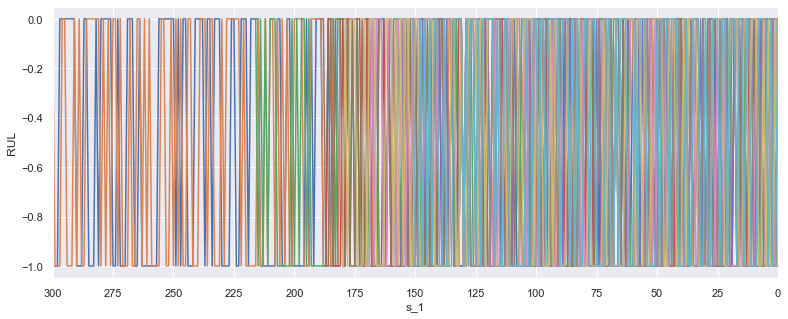

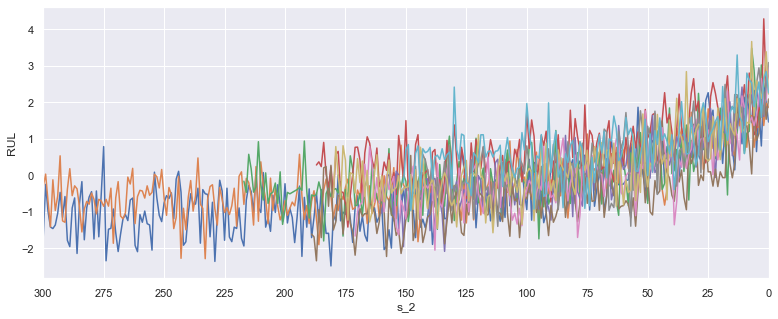

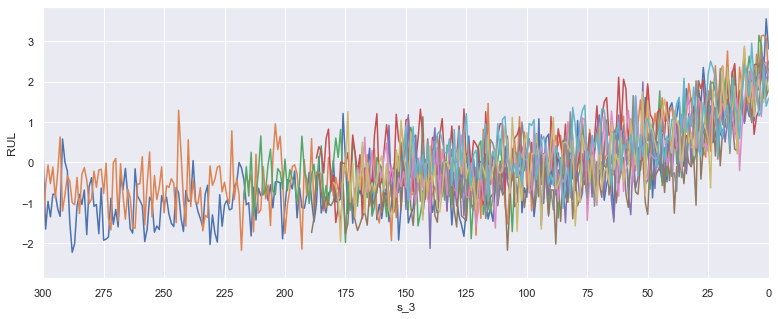

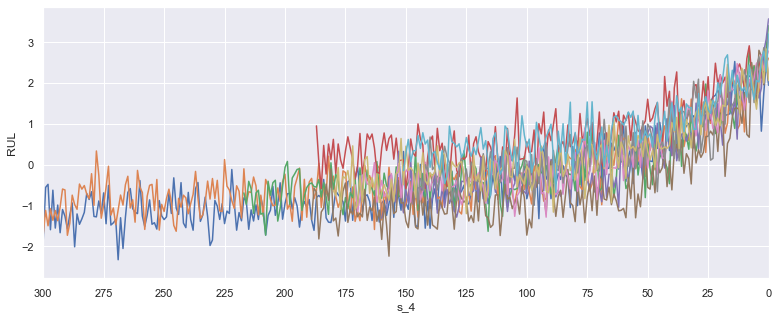

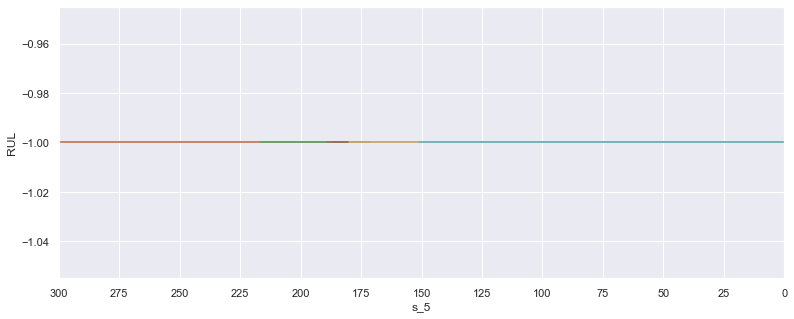

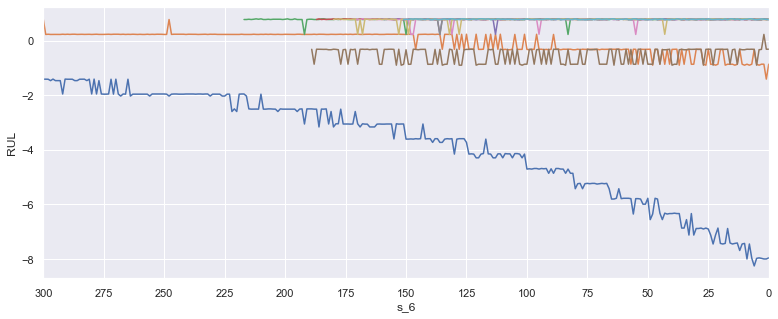

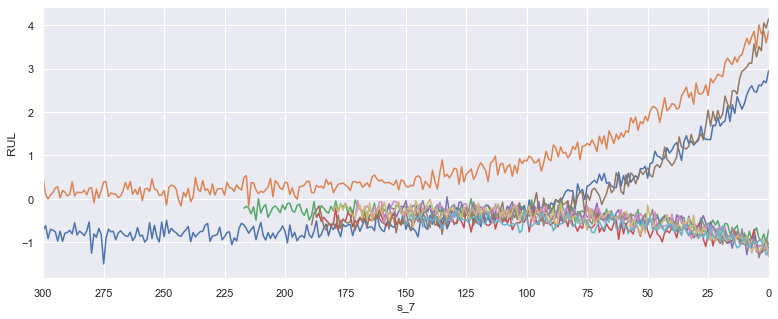

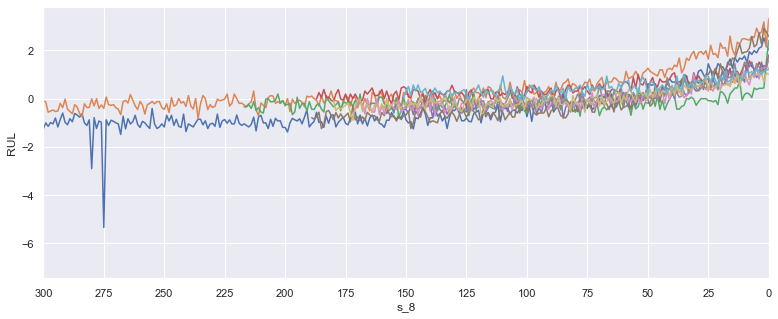

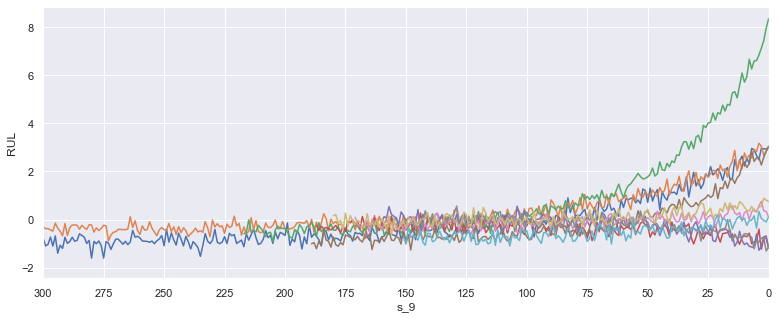

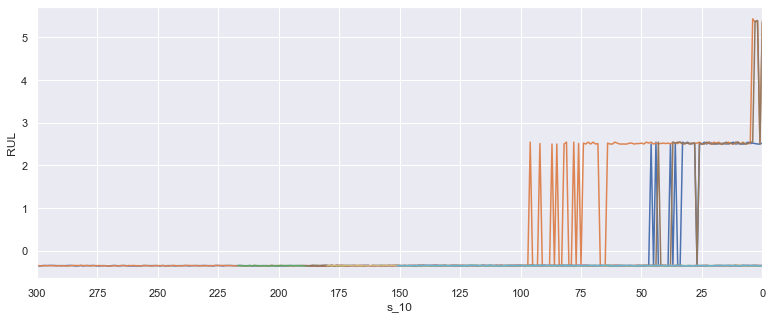

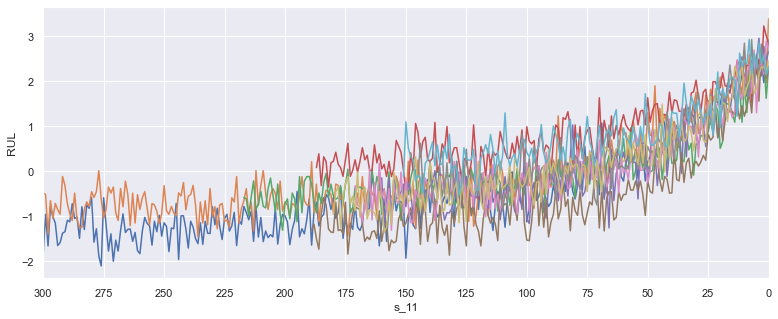

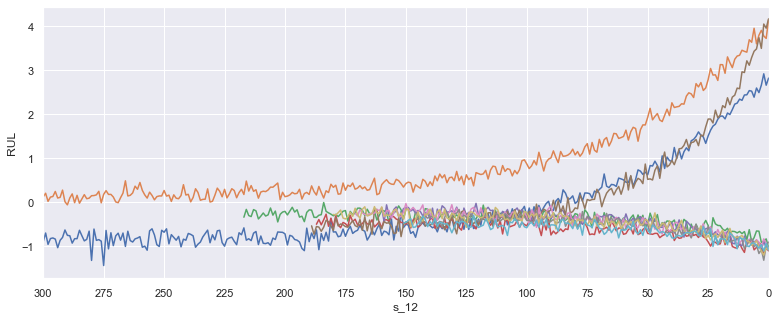

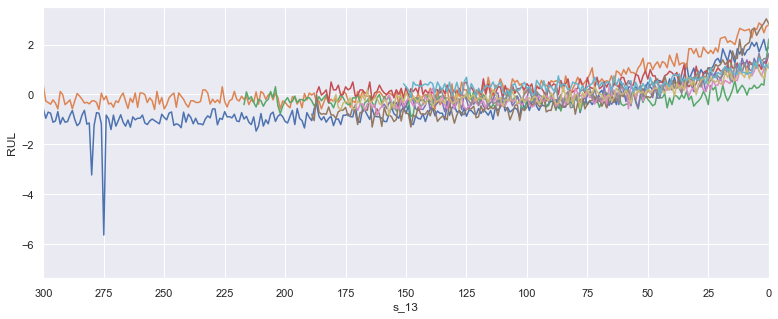

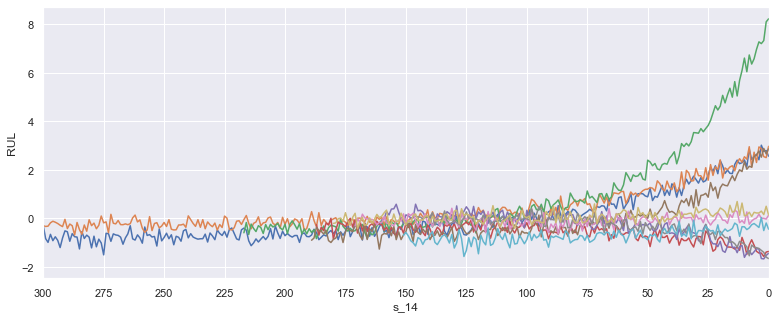

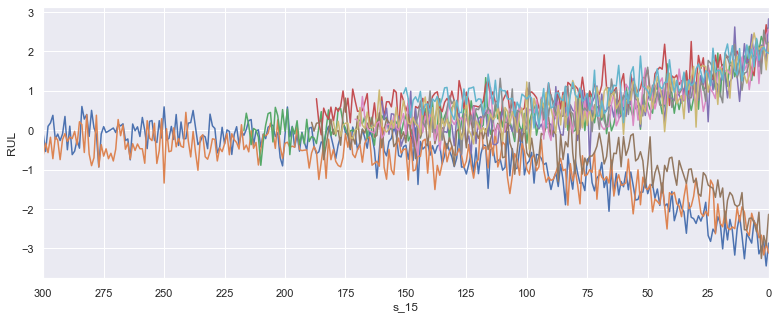

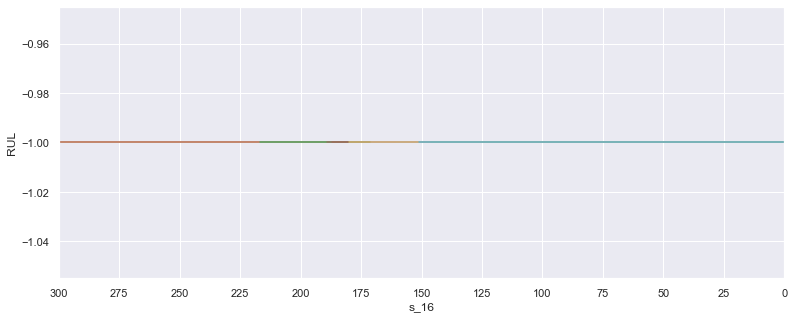

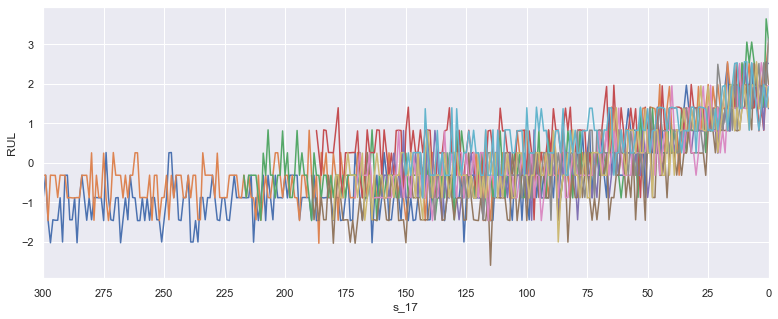

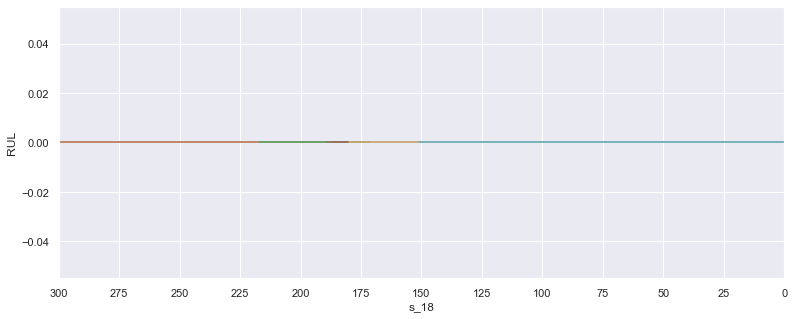

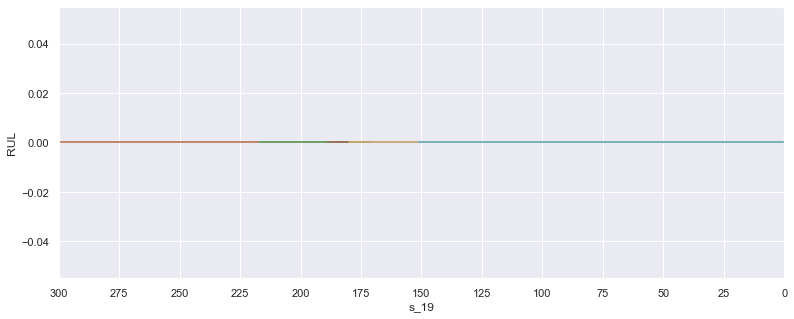

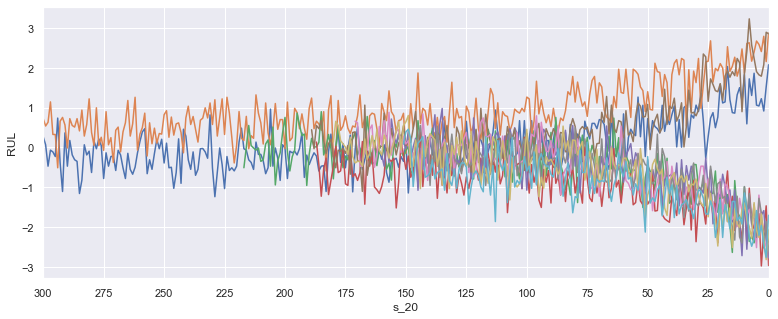

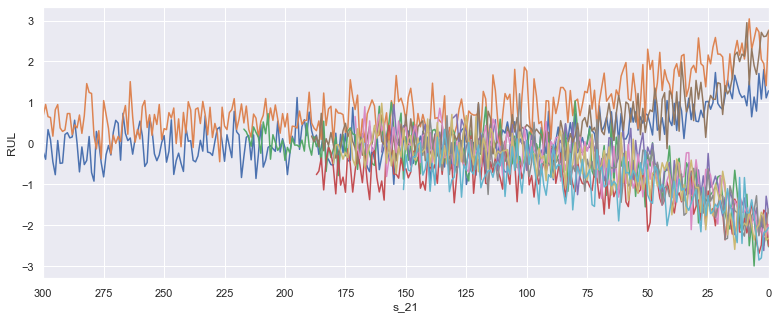

In [24]:
# plot each sensor to see if it seems useful at all

for sensor in sensor_names:
    plt.figure(figsize=(13,5))
    for i in train['unit_id'].unique():
        if (i % 10 == 0):
            plt.plot("RUL", sensor, data=X_train_condition_scaled[X_train_condition_scaled["unit_id"] == i])
    plt.xlim(300,0)
    plt.xlabel(sensor)
    plt.ylabel("RUL")
    plt.xticks(np.arange(0,325,25))
    plt.show()

Seonsors 1, 5, 6, 16, 18, and  seem to be pretty much just noise, so I am gonna drop em

In [25]:
drops = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']
keep = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

In [27]:
# need to format data for LSTM model. I did my best, this part is kinda hard.
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42) 
# so first we need to set how long our sequence is going to be
# in theory this is something we can play around with
sequence_length = 20

# also, added some clipping so that I don't capture steady state operations, and instead we are looking at degredation
train['RUL'].clip(upper=125, inplace=True)

# next, drop the columns we ain't gonna be using
train_dropped = train.drop(drops, axis=1)
test_dropped = test.drop(drops, axis=1)

# now, add operating condition as a string we can use as a conditional variable
# basically just combine the settings into a single string

train_dropped_co = add_op_co(train_dropped)
test_dropped_co = add_op_co(test_dropped)

# next we need to standardize the data
scaler = StandardScaler()



# using the condition to standardize. Initially just tried scaling everything, but this actually worked the best
for co in train_dropped_co['op_cond'].unique():
    scaler.fit(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    train_dropped_co.loc[train_dropped_co['op_cond']==co, keep] = scaler.transform(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    test_dropped_co.loc[test_dropped_co['op_cond']==co, keep] = scaler.transform(test_dropped_co.loc[test_dropped_co['op_cond']==co, keep])

# regular old scalar
train_dropped_co_reg_st = train_dropped_co.copy()
test_dropped_co_reg_st = test_dropped_co.copy()
for i in keep:
    train_dropped_co_reg_st[keep] = scaler.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_st[keep] = scaler.fit_transform(test_dropped_co[keep])

# minmax, which is what Azure team did

train_dropped_co_reg_mm = train_dropped_co.copy()
test_dropped_co_reg_mm = test_dropped_co.copy()
minmax = MinMaxScaler()
for i in keep:
    train_dropped_co_reg_mm[keep] = minmax.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_mm[keep] = minmax.fit_transform(test_dropped_co[keep])

# need to now split into train and validation sets. GSS is a pretty neat way to do it, given that we need to keep units intact (i.e. sequences stay within engine)
train_u = []
val_u = []
for train_index, val_index in gss.split(train_dropped_co['unit_id'].unique(), groups=train_dropped_co['unit_id'].unique()):
    train_u = [train_index]
    val_u = [val_index]

# these are the units we are gonna use in each split
train_units = train_dropped_co['unit_id'].unique()[train_u]
val_units = test_dropped_co['unit_id'].unique()[val_u]
print(train_units)

# now we need to shape the data into arrays and then sequences for the LSTM
# tried to use tensorflow, but it does not have enough flexibility to make the sequences
# since we need to keep engine data together

# define our feature columns:
# couple different ways to look at it

features_just_senors = keep
features_with_settings = setting_names.extend(keep)

# use generator to make generator for each engine, then wrap them up into a single generator

# first make validation testing sets

train_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_units)
train_split = np.concatenate(list(train_split_gen)).astype(np.float32)

val_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in val_units)
val_split = np.concatenate(list(val_split_gen)).astype(np.float32)

# lstm aslo requires labels for each sequence, which needs to be generated
# label is essentially the thing we are trying to predict or classify
# in Azure study, they classified based on if the engine would fail within x cycles
# since we are trying to predict RUL, we will use RUL

train_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_units]
train_labels = np.concatenate(list(train_labels_gen)).astype(np.float32)

val_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in val_units]
val_labels = np.concatenate(list(val_labels_gen)).astype(np.float32)

# Lastly, lets get the data for making predictions, using the full available dataset

train_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_dropped_co["unit_id"].unique())
train_array = np.concatenate(list(train_gen)).astype(np.float32)

train_labels_out_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_dropped_co["unit_id"].unique()]
train_array_labels = np.concatenate(list(train_labels_out_gen)).astype(np.float32)

# and now we need the test data
# in order to get more test data, we can add padding to get more sequences
# padding idea inspired by --> https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3

test_gen = (list(test_padding(test_dropped_co[test_dropped_co["unit_id"]==u], sequence_length, features_just_senors, -99.)) for u in test_dropped_co["unit_id"].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)
sensor_names
data = train[sensor_names].values
len(data)

len(train_split)

<ipython-input-27-d5a4ea0fbaee>:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_units = train_dropped_co['unit_id'].unique()[train_u]
<ipython-input-27-d5a4ea0fbaee>:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  val_units = test_dropped_co['unit_id'].unique()[val_u]


[  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100]


18492

In [28]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [29]:
len(train_split)
len(train_labels)

18492

In [30]:
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=5,
                   batch_size=32)

Epoch 1/5
578/578 [==============================] - 20s 17ms/step - loss: 7251.1997 - val_loss: 5486.3447
Epoch 2/5
578/578 [==============================] - 8s 13ms/step - loss: 4720.0776 - val_loss: 3613.5342
Epoch 3/5
578/578 [==============================] - 7s 13ms/step - loss: 3104.8308 - val_loss: 2336.5254
Epoch 4/5
578/578 [==============================] - 7s 13ms/step - loss: 2002.8695 - val_loss: 1481.1886
Epoch 5/5
578/578 [==============================] - 8s 14ms/step - loss: 1270.4967 - val_loss: 927.6194


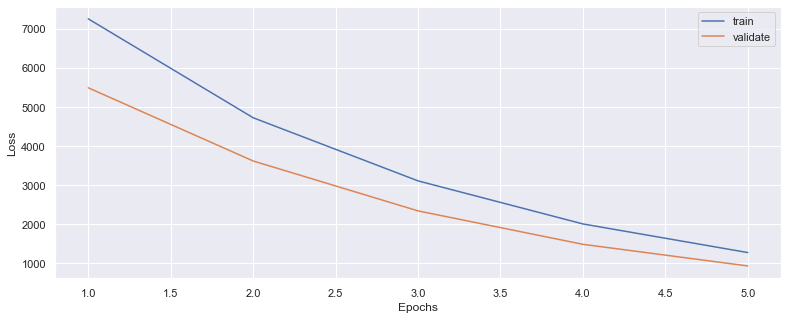

In [31]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [33]:

# predict and evaluate
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:31.38810157775879, R2:0.41922791425450323
Dataset: test RMSE:27.559956373871184, R2:0.5567505490614116


In [34]:

model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('simple_lstm_weights.h5')

history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
578/578 [==============================] - 20s 18ms/step - loss: 7251.1997 - val_loss: 5486.3447
Epoch 2/20
578/578 [==============================] - 7s 13ms/step - loss: 4720.0776 - val_loss: 3613.5342
Epoch 3/20
578/578 [==============================] - 8s 13ms/step - loss: 3104.8308 - val_loss: 2336.5254
Epoch 4/20
578/578 [==============================] - 7s 13ms/step - loss: 2002.8695 - val_loss: 1481.1886
Epoch 5/20
578/578 [==============================] - 7s 13ms/step - loss: 1270.4967 - val_loss: 927.6194
Epoch 6/20
578/578 [==============================] - 7s 13ms/step - loss: 803.7066 - val_loss: 596.2762
Epoch 7/20
578/578 [==============================] - 8s 14ms/step - loss: 522.9726 - val_loss: 402.8834
Epoch 8/20
578/578 [==============================] - 8s 13ms/step - loss: 367.4006 - val_loss: 320.5220
Epoch 9/20
578/578 [==============================] - 8s 13ms/step - loss: 286.5439 - val_loss: 280.1269
Epoch 10/20
578/578 [========================

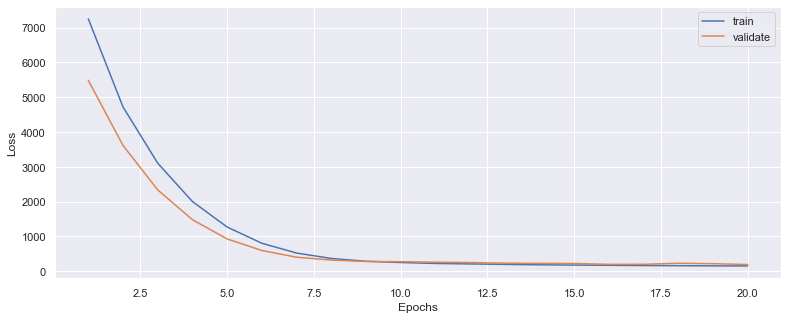

In [35]:
plot_loss(history)

In [38]:
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

Dataset: train RMSE:12.390970230102539, R2:0.9094921526290692
Dataset: test RMSE:17.62960005865125, R2:0.8186255640017259


### How to try different parameters?

In [ ]:
## ok lagged did NOT do better on the 50 length sequence!!
# Let's try some hyper-parameter tuning
# there are something like 100,000 possible configurations for the model, and all I have is
# my poor lenovo here

# as inspired by the azure team and other examples, I'm gonna just try some random sampling
# of params and pick the best performing one

# for data, lets use _, which so far has worked the best
# keep sequence length at 50, as that's the goal




# so first we need to set how long our sequence is going to be
# in theory this is something we can play around with
sequence_length = 50

# also, added some clipping so that I don't capture steady state operations, and instead we are looking at degredation
train['RUL'].clip(upper=125, inplace=True)

# next, drop the columns we ain't gonna be using
train_dropped = train.drop(drops, axis=1)
test_dropped = test.drop(drops, axis=1)

# now, add operating condition as a string we can use as a conditional variable
# basically just combine the settings into a single string

train_dropped_co = add_op_co(train_dropped)
test_dropped_co = add_op_co(test_dropped)

# next we need to standardize the data
scaler = StandardScaler()



# using the condition to standardize. Initially just tried scaling everything, but this actually worked the best
for co in train_dropped_co['op_cond'].unique():
    scaler.fit(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    train_dropped_co.loc[train_dropped_co['op_cond']==co, keep] = scaler.transform(train_dropped_co.loc[train_dropped_co['op_cond']==co, keep])
    test_dropped_co.loc[test_dropped_co['op_cond']==co, keep] = scaler.transform(test_dropped_co.loc[test_dropped_co['op_cond']==co, keep])

# regular old scalar
train_dropped_co_reg_st = train_dropped_co.copy()
test_dropped_co_reg_st = test_dropped_co.copy()
for i in keep:
    train_dropped_co_reg_st[keep] = scaler.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_st[keep] = scaler.fit_transform(test_dropped_co[keep])

# minmax, which is what Azure team did

train_dropped_co_reg_mm = train_dropped_co.copy()
test_dropped_co_reg_mm = test_dropped_co.copy()
minmax = MinMaxScaler()
for i in keep:
    train_dropped_co_reg_mm[keep] = minmax.fit_transform(train_dropped_co[keep])
    test_dropped_co_reg_mm[keep] = minmax.fit_transform(test_dropped_co[keep])

# need to now split into train and validation sets. GSS is a pretty neat way to do it, given that we need to keep units intact (i.e. sequences stay within engine)
train_u = []
val_u = []
for train_index, val_index in gss.split(train_dropped_co['unit_id'].unique(), groups=train_dropped_co['unit_id'].unique()):
    train_u = [train_index]
    val_u = [val_index]

# these are the units we are gonna use in each split
train_units = train_dropped_co['unit_id'].unique()[train_u]
val_units = test_dropped_co['unit_id'].unique()[val_u]
print(train_units)

# now we need to shape the data into arrays and then sequences for the LSTM
# tried to use tensorflow, but it does not have enough flexibility to make the sequences
# since we need to keep engine data together

# define our feature columns:
# couple different ways to look at it

features_just_senors = keep
features_with_settings = setting_names.extend(keep)

# use generator to make generator for each engine, then wrap them up into a single generator

# first make validation testing sets

train_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_units)
train_split = np.concatenate(list(train_split_gen)).astype(np.float32)

val_split_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in val_units)
val_split = np.concatenate(list(val_split_gen)).astype(np.float32)

# lstm aslo requires labels for each sequence, which needs to be generated
# label is essentially the thing we are trying to predict or classify
# in Azure study, they classified based on if the engine would fail within x cycles
# since we are trying to predict RUL, we will use RUL

train_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_units]
train_labels = np.concatenate(list(train_labels_gen)).astype(np.float32)

val_labels_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in val_units]
val_labels = np.concatenate(list(val_labels_gen)).astype(np.float32)

# Lastly, lets get the data for making predictions, using the full available dataset

train_gen = (list(gen_train_seq(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, features_just_senors)) for u in train_dropped_co["unit_id"].unique())
train_array = np.concatenate(list(train_gen)).astype(np.float32)

train_labels_out_gen = [label_generator(train_dropped_co[train_dropped_co["unit_id"]==u], sequence_length, ['RUL']) for u in train_dropped_co["unit_id"].unique()]
train_array_labels = np.concatenate(list(train_labels_out_gen)).astype(np.float32)

# and now we need the test data
# in order to get more test data, we can add padding to get more sequences
# padding idea inspired by --> https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3

test_gen = (list(test_padding(test_dropped_co[test_dropped_co["unit_id"]==u], sequence_length, features_just_senors, -99.)) for u in test_dropped_co["unit_id"].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

In [ ]:
# params to vary:


itterations = 20

epochs = [np.arange(10,40,5)]
nodes_list = [[50], [75], [100], [200], [50,100], [150, 250]]
dropouts = list(np.arange(1,5)/10)
function = ["sigmoid", "tanh", "relu"]

total_options = len(epochs)* len(nodes_list)*len(dropouts)* len(function)

ouput = []

# use the original block for building the sequences

for i in interations:
    
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
    model.add(LSTM(node, activation=fun)
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)
    
    y_hat_train = model.predict(train_array)
    get_rmse(train_array_labels, y_hat_train, 'train')

    y_hat_test = model.predict(test_array)
    get_rmse(y_test, y_hat_test)
              
    output.append([[i],[node,fun,]])

### Best Model

In [ ]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_split, train_labels,
                    validation_data=(val_split, val_labels),
                    epochs=20,
                   batch_size=32)
plot_loss(history)
y_hat_train = model.predict(train_array)
get_rmse(train_array_labels, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
get_rmse(y_test, y_hat_test)

Epoch 1/20
578/578 [==============================] - 25s 25ms/step - loss: 1639.5129 - val_loss: 509.0030
Epoch 2/20
578/578 [==============================] - 13s 23ms/step - loss: 773.9348 - val_loss: 316.0027
Epoch 3/20
578/578 [==============================] - 13s 22ms/step - loss: 687.3098 - val_loss: 334.2083
Epoch 4/20
578/578 [==============================] - 13s 23ms/step - loss: 643.3817 - val_loss: 326.9427
Epoch 5/20
578/578 [==============================] - 12s 22ms/step - loss: 598.6865 - val_loss: 280.4180
Epoch 6/20
578/578 [==============================] - 17s 30ms/step - loss: 563.4495 - val_loss: 397.5018
Epoch 7/20
578/578 [==============================] - 18s 30ms/step - loss: 524.0505 - val_loss: 258.6743
Epoch 8/20
578/578 [==============================] - 10s 17ms/step - loss: 531.0314 - val_loss: 232.0100 - lo - ETA: 0s - lo
Epoch 9/20
578/578 [==============================] - 9s 15ms/step - loss: 509.2710 - val_loss: 268.9834
Epoch 10/20
578/578 [=====